In [112]:
import tensorflow as tf
from tensorflow import keras
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

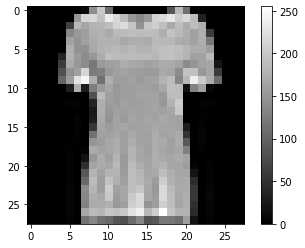

In [4]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [5]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

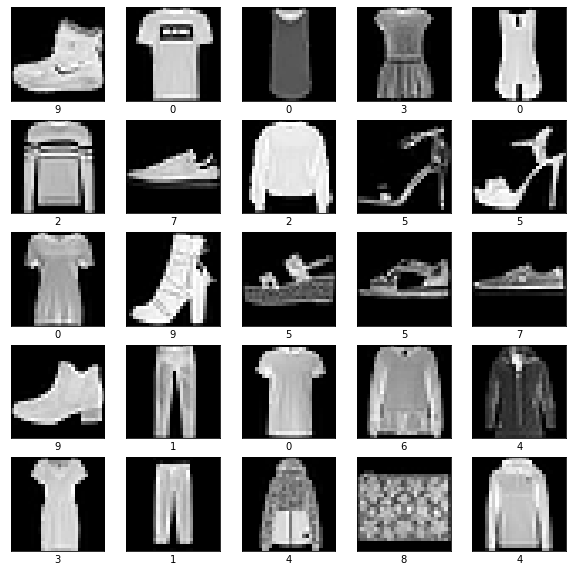

In [6]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Implementando PCA

In [10]:
train_images.shape

(60000, 28, 28)

Hay 60k observaciones con 28x28 (784) variables. Sin embargo para poder aplicar PCA y t-SNE sera necesario *aplanar* estas variables a un vector lineal de dimensiones 1x784, por lo que perderemos informacion de regiones o localidades.

In [14]:
train_images_flat = train_images.reshape(train_images.shape[0], -1)
train_images_flat.shape

(60000, 784)

Se normalizara la data restandole a cada variable la media de sus observaciones

In [25]:
train_images_normalized = train_images_flat - np.mean(train_images_flat, 0).reshape(1,-1)
train_images_normalized

array([[-8.00000000e-04, -5.78333333e-03, -3.00833333e-02, ...,
        -2.70633333e+00, -8.19000000e-01, -7.08833333e-02],
       [-8.00000000e-04, -5.78333333e-03, -3.00833333e-02, ...,
        -2.70633333e+00, -8.19000000e-01, -7.08833333e-02],
       [-8.00000000e-04, -5.78333333e-03, -3.00833333e-02, ...,
        -2.70633333e+00, -8.19000000e-01, -7.08833333e-02],
       ...,
       [-8.00000000e-04, -5.78333333e-03, -3.00833333e-02, ...,
        -2.70633333e+00, -8.19000000e-01, -7.08833333e-02],
       [-8.00000000e-04, -5.78333333e-03, -3.00833333e-02, ...,
        -2.70633333e+00, -8.19000000e-01, -7.08833333e-02],
       [-8.00000000e-04, -5.78333333e-03, -3.00833333e-02, ...,
        -2.70633333e+00, -8.19000000e-01, -7.08833333e-02]])

Usaremos numpy para calcular la matriz de covarianza junto con sus eigenvectors y eigenvalues

In [28]:
train_images_covariance = np.cov(train_images_normalized, rowvar = False)
train_images_covariance.shape

(784, 784)

In [33]:
train_cov_eigenvalues , train_cov_eigenvectors = np.linalg.eigh(train_images_covariance)

# Necesitamos los eigenvalues mas grandes y sus respectivos eigenvectors
# Por eso los ordenamos para que sea facil encontrar los n mayores eigenvalues usando slicing

eigenvalue_index = train_cov_eigenvalues.argsort()
sorted_eigenvalues = train_cov_eigenvalues[eigenvalue_index[::-1]]
sorted_eigenvectors = train_cov_eigenvectors[eigenvalue_index[::-1]]

sorted_eigenvalues

array([1.28813261e+06, 7.87596486e+05, 2.67002834e+05, 2.19903391e+05,
       1.70675684e+05, 1.53514062e+05, 1.03873558e+05, 8.45210295e+04,
       5.98768454e+04, 5.82987368e+04, 4.40423169e+04, 4.05104922e+04,
       3.39693045e+04, 2.92634594e+04, 2.69632622e+04, 2.61635152e+04,
       2.44829015e+04, 2.32659540e+04, 2.03196311e+04, 2.02058877e+04,
       1.92374928e+04, 1.80581769e+04, 1.70672351e+04, 1.65257703e+04,
       1.60181013e+04, 1.55545347e+04, 1.47820330e+04, 1.41662773e+04,
       1.36651584e+04, 1.30091044e+04, 1.22252852e+04, 1.17577135e+04,
       1.16974495e+04, 1.13484356e+04, 1.09215735e+04, 1.04641942e+04,
       1.02152835e+04, 1.00038024e+04, 9.69123623e+03, 9.28527356e+03,
       8.88419973e+03, 8.68269082e+03, 8.63610072e+03, 8.10796274e+03,
       7.77842693e+03, 7.62636456e+03, 7.48732299e+03, 7.27365472e+03,
       7.13761423e+03, 6.86872826e+03, 6.75557292e+03, 6.65572269e+03,
       6.51160412e+03, 6.35709951e+03, 6.13373817e+03, 6.07695548e+03,
      

Queremos 2 componentes principales, por lo que nos quedamos unicamente con los dos primeros eigenvectors

In [57]:
top_eigenvectors = sorted_eigenvectors[0:2, :]
top_eigenvectors.shape

(2, 784)

Finalmente nos quedamos con los componentes principales

In [76]:
train_images_pca = np.dot(top_eigenvectors,train_images_normalized.transpose()).transpose()
train_images_pca.shape

(60000, 2)

Determinamos cuanta varianza fue retenida por estos dos componentes:

In [74]:
# Sabemos que buscamos la varianza explicada por los dos primeros eigenvalues
np.sum(sorted_eigenvalues[0:2])/np.sum(sorted_eigenvalues)

0.4679453789952824

Se retuvo menos de la mitad de la varianza, pero cuando se considera que son solamente dos dimensiones de un total de 784, signifca que tenemos dos dimensiones particularmente buenas

# Implementacion de t-SNE

Usaremos la misma data normalizada que se uso para PCA para implementar t-SNE usando sklearn

In [77]:
train_images_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(train_images_normalized)
train_images_tsne.shape

(60000, 2)

# Clustering sin supervision de las representaciones reducidas
Ya se conoce el numero de clusters, 10, por lo que se usara este como valor de K en clustering de K Means y como numero de componentes en GMM

In [114]:
pca_kmeans = KMeans(n_clusters=10, random_state=0).fit_predict(train_images_pca)
tsne_kmeans = KMeans(n_clusters=10, random_state=0).fit_predict(train_images_tsne)

pca_gmm = GaussianMixture(n_components=10, random_state=0).fit_predict(train_images_pca)
tsne_gmm = GaussianMixture(n_components=10, random_state=0).fit_predict(train_images_tsne)

### PCA

[Text(0.5, 1.0, 'Labels originales')]

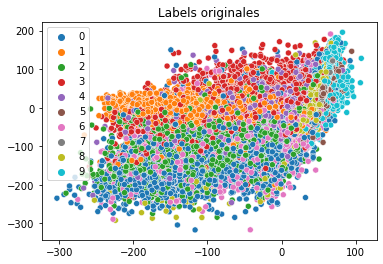

In [117]:
sns.scatterplot(x = train_images_pca[:, 0], 
                y = train_images_pca[:, 1], 
                hue = train_labels, 
                palette = sns.color_palette("tab10")).set(title='Labels originales')

Viendo la grafica de los labels como tal, es dificil encontrar un patron particular

[Text(0.5, 1.0, 'Labels de PCA')]

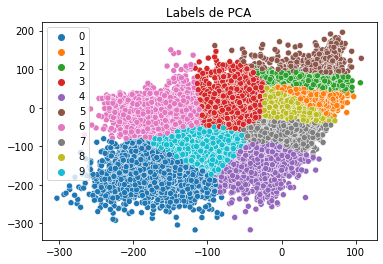

In [118]:
sns.scatterplot(x = train_images_pca[:, 0], 
                y = train_images_pca[:, 1], 
                hue = pca_kmeans, 
                palette = sns.color_palette("tab10")).set(title='Labels de PCA')

[Text(0.5, 1.0, 'Labels de GMM')]

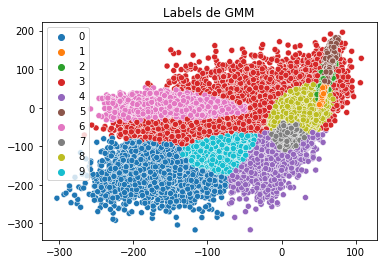

In [119]:
sns.scatterplot(x = train_images_pca[:, 0], 
                y = train_images_pca[:, 1], 
                hue = pca_gmm, 
                palette = sns.color_palette("tab10")).set(title='Labels de GMM')

Se puede obserar un reconocimiento de algunos patrones en GMM, como el cluster anaranjado siendo bastante parecido al cluster rosado. GMM tambien reconoce algunas cmbinaciones de patrones que se parecen a combinaciones de patrones en la data original, como los clusters cafe, verde y anaranjado de GMM comparado con los clusters verde ligero y parte del cluster celeste de los labels originales. Sin embargo, no necesariamente se puede decir que se realizo una clusterizacion adecuada

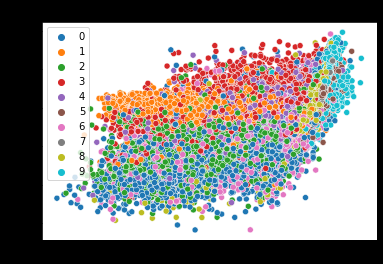
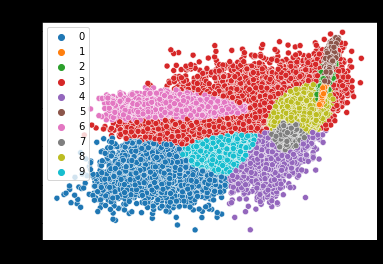

Por ptra parte, K-Means identifico patrones totalmente alienigenas a los labels originales.

### t-SNE

[Text(0.5, 1.0, 'Labels de orignales con t-SNE')]

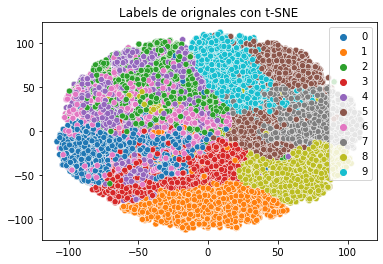

In [123]:
sns.scatterplot(x = train_images_tsne[:, 0], 
                y = train_images_tsne[:, 1], 
                hue = train_labels, 
                palette = sns.color_palette("tab10")).set(title='Labels de orignales con t-SNE')

[Text(0.5, 1.0, 'Labels de PCA con t-SNE')]

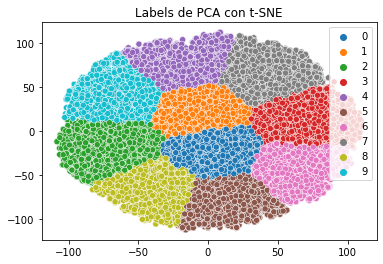

In [121]:
sns.scatterplot(x = train_images_tsne[:, 0], 
                y = train_images_tsne[:, 1], 
                hue = tsne_kmeans, 
                palette = sns.color_palette("tab10")).set(title='Labels de PCA con t-SNE')

[Text(0.5, 1.0, 'Labels de PCA con t-SNE')]

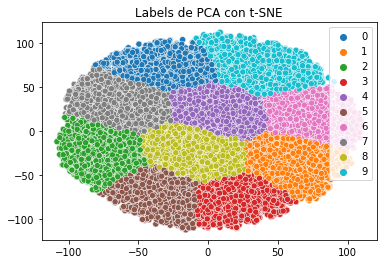

In [122]:
sns.scatterplot(x = train_images_tsne[:, 0], 
                y = train_images_tsne[:, 1], 
                hue = tsne_gmm, 
                palette = sns.color_palette("tab10")).set(title='Labels de PCA con t-SNE')

Es interesante notar que tanto K-Means como GMM encontraron clusters *muy* similares entre si, sin embargo estos clusters son demasiado regulares y simetricos como para representar adecuadamente los labels originales.

Sin embargo, se debe observar que, en sentido de las manecillas del reloj, los clusters de GMM y KMeans que estan entre la hora 3 hasta la hora 6 si parecen ser representativos de los datos originales, por lo que la clusterizacion no fue del todo mala, pero sigue siendo lejos de ser adecuada.

# Conclusiones

Utilizando reduccion de dimensionalidad se logro representar imagenes de 784 dimensiones en tan solo 2 dimensiones. Por motivos obvios se presento una gran perdida de informacion al hacer esto, de hecho se pierde suficiente informacion como para que se dificulte encontrar clusters representativos de los datos originales. Sin embargo, los clusters encontrados *no* son totalmente erroneos y se se puede llegar a discernir cierta fidelidad en algunos clusters, y este es el resultado que realmente vale la pena señalar, con menos del 1% de las dimensiones originales se logro conservar alrededor del 46% de la informacion original (al menos con PCA) y esto es sorprendente. Si se utilizacen mas dimensiones en la reduccion o bien si se lograse una manera de integrar la informacion de localidad de los datos entonces se podria crear una herramienta poderosa para la reduccion de dimensionalidad de imagenes que conserva gran cantidad de la informacion.